# Notebook 5.1 - Choice of transformations and model

# Import libraries

In [83]:
#Import all libraries that are relevant across models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from scipy import stats
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Choose the city

In [84]:
# Choose the city ('Madrid', 'Barcelona', 'Valencia', or 'Combined')
city = 'Combined'

# Load the cleaned data sets

In [85]:
if city.lower() == 'madrid':
    data = pd.read_csv('../../data/4_data_cleaned/madrid_cleaned_base_features.csv')
elif city.lower() == 'barcelona':
    data = pd.read_csv('../../data/4_data_cleaned/barcelona_cleaned_base_features.csv')
elif city.lower() == 'valencia':
    data = pd.read_csv('../../data/4_data_cleaned/valencia_cleaned_base_features.csv')
elif city.lower() == 'combined':
    #Read all 3 datasets and add a column to indicate source dataset
    madrid_df = pd.read_csv('../../data/4_data_cleaned/madrid_cleaned_base_features.csv')
    valencia_df = pd.read_csv('../../data/4_data_cleaned/valencia_cleaned_base_features.csv')
    barcelona_df = pd.read_csv('../../data/4_data_cleaned/barcelona_cleaned_base_features.csv')
    madrid_df['Madrid'] = True
    madrid_df['Valencia'] = False
    madrid_df['Barcelona'] = False    
    valencia_df['Madrid'] = False
    valencia_df['Valencia'] = True
    valencia_df['Barcelona'] = False    
    barcelona_df['Madrid'] = False
    barcelona_df['Valencia'] = False
    barcelona_df['Barcelona'] = True
    data = pd.concat([madrid_df, valencia_df, barcelona_df], ignore_index=True)

__Inspect cleaned data__

In [86]:
data.head()

,ASSETID,PRICE,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,AMENITYID,HASPARKINGSPACE,PARKINGSPACEPRICE,HASTERRACE,HASLIFT,...,LATITUDE,NEIGHBORHOOD,ZIP_CODE,PERIOD_201803,PERIOD_201806,PERIOD_201809,PERIOD_201812,Madrid,Valencia,Barcelona
0,A10000037964896093228,255000,97,3,2,3,0,1.0,0,1,...,40.473921,Pinar del Rey,28033,0,0,1,0,True,False,False
1,A10000072440601830803,82000,62,2,1,3,0,1.0,0,1,...,40.384968,Palomeras sureste,28018,0,1,0,0,True,False,False
2,A10000538600815177437,133000,67,3,1,3,0,1.0,1,0,...,40.384547,San Diego,28018,1,0,0,0,True,False,False
3,A10000654405436195291,204000,180,3,2,3,0,1.0,0,1,...,40.430336,Ventas,28017,1,0,0,0,True,False,False
4,A10000872160480475600,161000,54,2,1,3,0,1.0,0,0,...,40.384103,Buena Vista,28019,0,0,0,1,True,False,False


# Defining X and y

__Implementing Box-Cox transformation to target variable PRICE__

- Check that there are no negative or zero values (required for Box-Cox)

In [87]:
negative_or_zero_price_count = data[data['PRICE'] <= 0].shape[0]

print(f"Number of rows where PRICE is negative or zero: {negative_or_zero_price_count}")

Number of rows where PRICE is negative or zero: 0


- Find the optimal lambda for the Box-Cox transformation (optimizing for normal distribution)

In [88]:
_, lambda_ = stats.boxcox(data['PRICE'])

# Print the optimal lambda
print(f"Lambda used for Box-Cox transformation: {lambda_}")

Lambda used for Box-Cox transformation: -0.13920487350932267


- Compare distribution after Box-Cox and alternative log-transformation

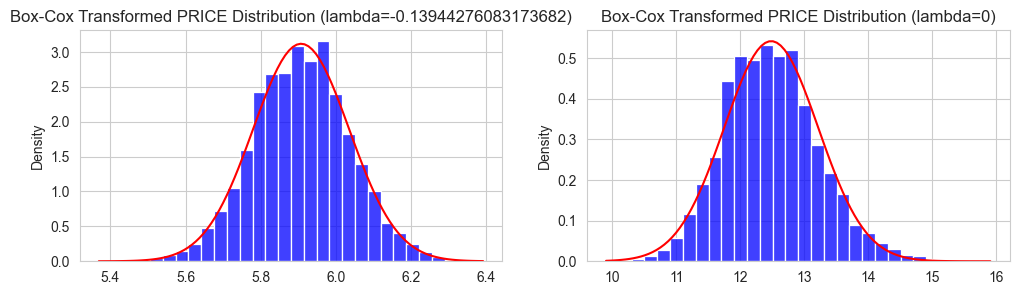

In [89]:
# Apply Box-Cox transformation of optimized lambda
lambda_1 = -0.13944276083173682
price_transformed_lambda1 = stats.boxcox(data['PRICE'], lmbda=lambda_1)

# Apply Box-Cox transformation with lambda = 0 (equivalent to log transformation)
lambda_2 = 0
price_transformed_lambda2 = stats.boxcox(data['PRICE'], lmbda=lambda_2)

# Plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# Box-Cox transformation with lambda = -0.13
sns.histplot(price_transformed_lambda1, kde=False, ax=axes[0], stat="density", color="blue", bins=30)
axes[0].set_title(f'Box-Cox Transformed PRICE Distribution (lambda={lambda_1})')
# Add normal distribution line
mean1, std1 = np.mean(price_transformed_lambda1), np.std(price_transformed_lambda1)
x1 = np.linspace(min(price_transformed_lambda1), max(price_transformed_lambda1), 100)
axes[0].plot(x1, stats.norm.pdf(x1, mean1, std1), color='red')

# Box-Cox transformation with lambda = 0 (log transformation)
sns.histplot(price_transformed_lambda2, kde=False, ax=axes[1], stat="density", color="blue", bins=30)
axes[1].set_title(f'Box-Cox Transformed PRICE Distribution (lambda={lambda_2})')
# Add normal distribution line
mean2, std2 = np.mean(price_transformed_lambda2), np.std(price_transformed_lambda2)
x2 = np.linspace(min(price_transformed_lambda2), max(price_transformed_lambda2), 100)
axes[1].plot(x2, stats.norm.pdf(x2, mean2, std2), color='red')

plt.show()

- Implement Box_Cox transformation with different specified lambdas
- Better performance metrics achieved with lambda equal to zero (same as log-transformation)

In [90]:
# Define the lambda value
specified_lambda = 0

# Apply Box-Cox transformation using the specified lambda value
price_transformed = stats.boxcox(data['PRICE'], lmbda=specified_lambda)

# Add the transformed PRICE back to the DataFrame
data['PRICE_TRANSFORMED'] = price_transformed

__Assign features as X and target as Y__

In [91]:
X = data.drop(columns=['PRICE', 'PRICE_TRANSFORMED'])
y = data['PRICE_TRANSFORMED']

### Dropping features not relevant for modelling

In [92]:
#Drop ASSETID as it is only an identifier, drop ZIP_CODE as the base model only includes base features
X = X.drop(columns=['ASSETID', 'ZIP_CODE'])

### Splitting the data into training and test sets

In [93]:
# Split the dataset into training and testing set with 7:3 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (104827, 43)
X_test shape: (44927, 43)
y_train shape: (104827,)
y_test shape: (44927,)


# Target encoding of base feature neighborhood

In [94]:
# Calculate average LOG_PRICE for each NEIGHBORHOOD only with training set
neighborhood_means = y_train.groupby(X_train['NEIGHBORHOOD']).mean()

# Assign average means to both training and test set
X_train['NEIGHBORHOOD_ENCODED'] = X_train['NEIGHBORHOOD'].map(neighborhood_means)
X_test['NEIGHBORHOOD_ENCODED'] = X_test['NEIGHBORHOOD'].map(neighborhood_means)

# Drop the NEIGHBORHOOD column from both training and testing sets
X_train = X_train.drop(columns=['NEIGHBORHOOD'])
X_test = X_test.drop(columns=['NEIGHBORHOOD'])

# Inspecting final data before running models   

In [95]:
X_test.head()

,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,AMENITYID,HASPARKINGSPACE,PARKINGSPACEPRICE,HASTERRACE,HASLIFT,HASAIRCONDITIONING,HASNORTHORIENTATION,...,LONGITUDE,LATITUDE,PERIOD_201803,PERIOD_201806,PERIOD_201809,PERIOD_201812,Madrid,Valencia,Barcelona,NEIGHBORHOOD_ENCODED
55930,82,3,2,3,0,1.0,0,1,0,0,...,-3.671317,40.406918,0,1,0,0,True,False,False,13.275478
110070,86,3,1,3,0,1.0,1,1,1,0,...,2.200005,41.416478,0,0,1,0,False,False,True,12.368969
133225,93,4,1,3,0,1.0,1,1,0,0,...,2.209844,41.419345,0,0,1,0,False,False,True,12.092169
57088,40,1,1,3,1,1.0,0,1,1,0,...,-3.594361,40.358942,0,0,0,1,True,False,False,12.247304
103352,84,3,2,3,0,1.0,0,0,0,0,...,2.172524,41.377668,1,0,0,0,False,False,True,12.413428


In [96]:
y_test.head()

55930     12.914108
110070    12.570716
133225    12.454884
57088     11.798104
103352    12.807653
Name: PRICE_TRANSFORMED, dtype: float64

# Running different models with GridSearch to optimize hyperparameters

# Linear regression

In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions in Box-Cox transformed scale
y_pred_boxcox_lr = lr_model.predict(X_test_scaled)

# Transform predictions back to the original scale
y_pred_lr_price = inv_boxcox(y_pred_boxcox_lr, specified_lambda)
y_test_price = inv_boxcox(y_test, specified_lambda)

# Evaluation metrics on the original scale
mae_lr_price = mean_absolute_error(y_test_price, y_pred_lr_price)
mse_lr_price = mean_squared_error(y_test_price, y_pred_lr_price)
rmse_lr_price = np.sqrt(mse_lr_price)
mape_lr_price = mean_absolute_percentage_error(y_test_price, y_pred_lr_price)

# Evaluation metrics on the Box-Cox transformed scale
mae_boxcox_lr = mean_absolute_error(y_test, y_pred_boxcox_lr)
mse_boxcox_lr = mean_squared_error(y_test, y_pred_boxcox_lr)
rmse_boxcox_lr = np.sqrt(mse_boxcox_lr)
mape_boxcox_lr = mean_absolute_percentage_error(y_test, y_pred_boxcox_lr)

# Print the metrics
print("Metrics on the original PRICE scale:")
print(f"MAE: {mae_lr_price:.4f}")
print(f"MSE: {mse_lr_price:.4f}")
print(f"RMSE: {rmse_lr_price:.4f}")
print(f"MAPE: {mape_lr_price:.4f}")

print("\nMetrics on the Box-Cox transformed scale:")
print(f"MAE: {mae_boxcox_lr:.4f}")
print(f"MSE: {mse_boxcox_lr:.4f}")
print(f"RMSE: {rmse_boxcox_lr:.4f}")
print(f"MAPE: {mape_boxcox_lr:.4f}")


Metrics on the original PRICE scale:
MAE: 79332.1560
MSE: 116671961016.6329
RMSE: 341572.7756
MAPE: 0.2070

Metrics on the Box-Cox transformed scale:
MAE: 0.1969
MSE: 0.0691
RMSE: 0.2628
MAPE: 0.0158


In [81]:
# Permutation importance
perm_importance = permutation_importance(lr_model, X_test, y_test, random_state=42)
lr_perm_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': perm_importance.importances_mean
}).sort_values(by='importance', ascending=False)

# Print results
print("Linear Regression Permutation Importance:")
print(lr_perm_importance_df)

C:\Users\hanten carlotta\PycharmProjects\Capstone\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\hanten carlotta\PycharmProjects\Capstone\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\hanten carlotta\PycharmProjects\Capstone\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\hanten carlotta\PycharmProjects\Capstone\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\hanten carlotta\PycharmProjects\Capstone\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Us

Linear Regression Permutation Importance:
                    feature    importance
38            PERIOD_201812  6.026439e+22
35            PERIOD_201803  4.639068e+22
37            PERIOD_201809  3.549084e+22
36            PERIOD_201806  2.983774e+22
41                Barcelona  1.235625e+20
39                   Madrid  1.102111e+20
40                 Valencia  6.705593e+19
33                LONGITUDE  3.787289e+10
30  DISTANCE_TO_CITY_CENTER  7.046431e+08
22               FLOORCLEAN  3.019899e+07
1                ROOMNUMBER  2.013266e+07
29            BUILTTYPEID_3  3.355443e+06
3                 AMENITYID  3.355443e+06
18                 ISDUPLEX  0.000000e+00
32  DISTANCE_TO_MAIN_STREET  0.000000e+00
23      CADMAXBUILDINGFLOOR  0.000000e+00
19                 ISSTUDIO  0.000000e+00
21             ISINTOPFLOOR  0.000000e+00
17                HASGARDEN  0.000000e+00
12       HASWESTORIENTATION  0.000000e+00
9       HASNORTHORIENTATION  0.000000e+00
10      HASSOUTHORIENTATION  0.000

C:\Users\hanten carlotta\PycharmProjects\Capstone\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\hanten carlotta\PycharmProjects\Capstone\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


### Random Forest Regressor

In [82]:
from sklearn.ensemble import RandomForestRegressor
# Define parameter grid for GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search
rf_grid = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid_rf,
                       cv=3, verbose=2, n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_model = rf_grid.best_estimator_

# Predictions in Box-Cox transformed scale
y_pred_boxcox_rf = rf_model.predict(X_test)

# Transform predictions back to the original scale
y_pred_rf_price = inv_boxcox(y_pred_boxcox_rf, specified_lambda)
y_test_price = inv_boxcox(y_test, specified_lambda)

# Evaluation metrics on the original scale
mae_rf_price = mean_absolute_error(y_test_price, y_pred_rf_price)
mse_rf_price = mean_squared_error(y_test_price, y_pred_rf_price)
rmse_rf_price = np.sqrt(mse_rf_price)
mape_rf_price = mean_absolute_percentage_error(y_test_price, y_pred_rf_price)

# Evaluation metrics on the Box-Cox transformed scale
mae_boxcox_rf = mean_absolute_error(y_test, y_pred_boxcox_rf)
mse_boxcox_rf = mean_squared_error(y_test, y_pred_boxcox_rf)
rmse_boxcox_rf = np.sqrt(mse_boxcox_rf)
mape_boxcox_rf = mean_absolute_percentage_error(y_test, y_pred_boxcox_rf)

# Print the metrics
print("Metrics on the original PRICE scale:")
print(f"MAE: {mae_rf_price:.4f}")
print(f"MSE: {mse_rf_price:.4f}")
print(f"RMSE: {rmse_rf_price:.4f}")
print(f"MAPE: {mape_rf_price:.4f}")

print("\nMetrics on the Box-Cox transformed scale:")
print(f"MAE: {mae_boxcox_rf:.4f}")
print(f"MSE: {mse_boxcox_rf:.4f}")
print(f"RMSE: {rmse_boxcox_rf:.4f}")
print(f"MAPE: {mape_boxcox_rf:.4f}")

Fitting 3 folds for each of 324 candidates, totalling 972 fits


KeyboardInterrupt: 

In [ ]:
# Print the best parameters
print("Best Parameters found by GridSearchCV:")
print(rf_grid.best_params_)

In [ ]:
# Permutation importance
perm_importance = permutation_importance(rf_model, X_test, y_test, random_state=42)
rf_perm_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': perm_importance.importances_mean
}).sort_values(by='importance', ascending=False)

# Print results
print("Random Forest Permutation Importance:")
print(rf_perm_importance_df)

### XGBoost

In [ ]:
import xgboost as xgb
# Define parameter grid for GridSearchCV
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Grid search
xgb_grid = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_grid_xgb,
                        cv=3, verbose=2, n_jobs=-1)
xgb_grid.fit(X_train, y_train)
xgb_model = xgb_grid.best_estimator_

# Predictions in Box-Cox transformed scale
y_pred_boxcox_xgb = xgb_model.predict(X_test)

# Transform predictions back to the original scale
y_pred_xgb_price = inv_boxcox(y_pred_boxcox_xgb, specified_lambda)
y_test_price = inv_boxcox(y_test, specified_lambda)

# Evaluation metrics on the original scale
mae_xgb_price = mean_absolute_error(y_test_price, y_pred_xgb_price)
mse_xgb_price = mean_squared_error(y_test_price, y_pred_xgb_price)
rmse_xgb_price = np.sqrt(mse_xgb_price)
mape_xgb_price = mean_absolute_percentage_error(y_test_price, y_pred_xgb_price)

# Evaluation metrics on the Box-Cox transformed scale
mae_boxcox_xgb = mean_absolute_error(y_test, y_pred_boxcox_xgb)
mse_boxcox_xgb = mean_squared_error(y_test, y_pred_boxcox_xgb)
rmse_boxcox_xgb = np.sqrt(mse_boxcox_xgb)
mape_boxcox_xgb = mean_absolute_percentage_error(y_test, y_pred_boxcox_xgb)

# Print the metrics
print("Metrics on the original PRICE scale:")
print(f"MAE: {mae_xgb_price:.4f}")
print(f"MSE: {mse_xgb_price:.4f}")
print(f"RMSE: {rmse_xgb_price:.4f}")
print(f"MAPE: {mape_xgb_price:.4f}")

print("\nMetrics on the Box-Cox transformed scale:")
print(f"MAE: {mae_boxcox_xgb:.4f}")
print(f"MSE: {mse_boxcox_xgb:.4f}")
print(f"RMSE: {rmse_boxcox_xgb:.4f}")
print(f"MAPE: {mape_boxcox_xgb:.4f}")

Fitting 3 folds for each of 324 candidates, totalling 972 fits


In [ ]:
# Permutation importance
perm_importance = permutation_importance(xgb_model, X_test, y_test, random_state=42)
xgb_perm_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': perm_importance.importances_mean
}).sort_values(by='importance', ascending=False)

# Print results
print("XGBoost Permutation Importance:")
print(xgb_perm_importance_df)

In [ ]:
# Print the best parameters
print("Best Parameters found by GridSearchCV:")
print(xgb_grid.best_params_)

### CatBoost

In [ ]:
from catboost import CatBoostRegressor

# Define parameter grid for GridSearchCV
param_grid_catboost = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Grid search
catboost_grid = GridSearchCV(estimator=CatBoostRegressor(verbose=0), param_grid=param_grid_catboost,
                             cv=3, verbose=2, n_jobs=-1)
catboost_grid.fit(X_train, y_train)
catboost_model = catboost_grid.best_estimator_

# Predictions in Box-Cox transformed scale
y_pred_boxcox_catboost = catboost_model.predict(X_test)

# Transform predictions back to the original scale
y_pred_catboost_price = inv_boxcox(y_pred_boxcox_catboost, specified_lambda)
y_test_price = inv_boxcox(y_test, specified_lambda)

# Evaluation metrics on the original scale
mae_catboost_price = mean_absolute_error(y_test_price, y_pred_catboost_price)
mse_catboost_price = mean_squared_error(y_test_price, y_pred_catboost_price)
rmse_catboost_price = np.sqrt(mse_catboost_price)
mape_catboost_price = mean_absolute_percentage_error(y_test_price, y_pred_catboost_price)

# Evaluation metrics on the Box-Cox transformed scale
mae_boxcox_catboost = mean_absolute_error(y_test, y_pred_boxcox_catboost)
mse_boxcox_catboost = mean_squared_error(y_test, y_pred_boxcox_catboost)
rmse_boxcox_catboost = np.sqrt(mse_boxcox_catboost)
mape_boxcox_catboost = mean_absolute_percentage_error(y_test, y_pred_boxcox_catboost)

# Print the metrics
print("Metrics on the original PRICE scale:")
print(f"MAE: {mae_catboost_price:.4f}")
print(f"MSE: {mse_catboost_price:.4f}")
print(f"RMSE: {rmse_catboost_price:.4f}")
print(f"MAPE: {mape_catboost_price:.4f}")

print("\nMetrics on the Box-Cox transformed scale:")
print(f"MAE: {mae_boxcox_catboost:.4f}")
print(f"MSE: {mse_boxcox_catboost:.4f}")
print(f"RMSE: {rmse_boxcox_catboost:.4f}")
print(f"MAPE: {mape_boxcox_catboost:.4f}")

In [ ]:
# Permutation importance
perm_importance = permutation_importance(catboost_model, X_test, y_test, random_state=42)
catboost_perm_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': perm_importance.importances_mean
}).sort_values(by='importance', ascending=False)

# Print results
print("CatBoost Permutation Importance:")
print(catboost_perm_importance_df)

In [ ]:
# Print the best parameters
print("Best Parameters found by GridSearchCV:")
print(catboost_grid.best_params_)

### LightGBM

In [ ]:
import lightgbm as lgb

# Define parameter grid for GridSearchCV
param_grid_lgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [20, 31, 40, 50],
    'max_depth': [10, 20, 30, None],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Grid search
lgb_grid = GridSearchCV(estimator=lgb.LGBMRegressor(), param_grid=param_grid_lgb,
                        cv=3, verbose=2, n_jobs=-1)
lgb_grid.fit(X_train, y_train)
lgb_model = lgb_grid.best_estimator_

# Predictions in Box-Cox transformed scale
y_pred_boxcox_lgb = lgb_model.predict(X_test)

# Transform predictions back to the original scale
y_pred_lgb_price = inv_boxcox(y_pred_boxcox_lgb, specified_lambda)
y_test_price = inv_boxcox(y_test, specified_lambda)

# Evaluation metrics on the original scale
mae_lgb_price = mean_absolute_error(y_test_price, y_pred_lgb_price)
mse_lgb_price = mean_squared_error(y_test_price, y_pred_lgb_price)
rmse_lgb_price = np.sqrt(mse_lgb_price)
mape_lgb_price = mean_absolute_percentage_error(y_test_price, y_pred_lgb_price)

# Evaluation metrics on the Box-Cox transformed scale
mae_boxcox_lgb = mean_absolute_error(y_test, y_pred_boxcox_lgb)
mse_boxcox_lgb = mean_squared_error(y_test, y_pred_boxcox_lgb)
rmse_boxcox_lgb = np.sqrt(mse_boxcox_lgb)
mape_boxcox_lgb = mean_absolute_percentage_error(y_test, y_pred_boxcox_lgb)

# Print the metrics
print("Metrics on the original PRICE scale:")
print(f"MAE: {mae_lgb_price:.4f}")
print(f"MSE: {mse_lgb_price:.4f}")
print(f"RMSE: {rmse_lgb_price:.4f}")
print(f"MAPE: {mape_lgb_price:.4f}")

print("\nMetrics on the Box-Cox transformed scale:")
print(f"MAE: {mae_boxcox_lgb:.4f}")
print(f"MSE: {mse_boxcox_lgb:.4f}")
print(f"RMSE: {rmse_boxcox_lgb:.4f}")
print(f"MAPE: {mape_boxcox_lgb:.4f}")

In [ ]:
# Permutation importance
perm_importance = permutation_importance(lgb_model, X_test, y_test, random_state=42)
lgb_perm_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': perm_importance.importances_mean
}).sort_values(by='importance', ascending=False)

# Print results
print("LightGBM Permutation Importance:")
print(lgb_perm_importance_df)

In [ ]:
# Print the best parameters
print("Best Parameters found by GridSearchCV:")
print(lgb_grid.best_params_)

### Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Neural Network
nn_model = Sequential()
nn_model.add(Input(shape=(X_train.shape[1],)))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with early stopping
nn_model.fit(X_train_scaled, y_train, 
             epochs=100, 
             batch_size=32, 
             verbose=0, 
             validation_split=0.2, 
             callbacks=[early_stopping])

y_pred_boxcox_nn = nn_model.predict(X_test_scaled).flatten()

# Transform predictions back to the original scale
y_pred_nn_price = inv_boxcox(y_pred_boxcox_nn, specified_lambda)
y_test_price = inv_boxcox(y_test, specified_lambda)

# Evaluation metrics on the original scale
mae_nn_price = mean_absolute_error(y_test_price, y_pred_nn_price)
mse_nn_price = mean_squared_error(y_test_price, y_pred_nn_price)
rmse_nn_price = np.sqrt(mse_nn_price)
mape_nn_price = mean_absolute_percentage_error(y_test_price, y_pred_nn_price)

# Evaluation metrics on the Box-Cox transformed scale
mae_boxcox_nn = mean_absolute_error(y_test, y_pred_boxcox_nn)
mse_boxcox_nn = mean_squared_error(y_test, y_pred_boxcox_nn)
rmse_boxcox_nn = np.sqrt(mse_boxcox_nn)
mape_boxcox_nn = mean_absolute_percentage_error(y_test, y_pred_boxcox_nn)

# Print the metrics
print("Metrics on the original PRICE scale:")
print(f"MAE: {mae_nn_price:.4f}")
print(f"MSE: {mse_nn_price:.4f}")
print(f"RMSE: {rmse_nn_price:.4f}")
print(f"MAPE: {mape_nn_price:.4f}")

print("\nMetrics on the Box-Cox transformed scale:")
print(f"MAE: {mae_boxcox_nn:.4f}")
print(f"MSE: {mse_boxcox_nn:.4f}")
print(f"RMSE: {rmse_boxcox_nn:.4f}")
print(f"MAPE: {mape_boxcox_nn:.4f}")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Define the function to create the Keras model
def create_model(optimizer='adam', neurons1=64, neurons2=32, activation='relu'):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(neurons1, activation=activation))
    model.add(Dense(neurons2, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the KerasRegressor
model = KerasRegressor(model=create_model, verbose=0)

# Define the grid search parameters for epochs only
param_grid = {
    'epochs': [50, 100, 200, 300]
}

# Define the scoring function
def my_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(my_scorer, greater_is_better=False)

# Create GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=3)

# Fit the model with GridSearchCV
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

try:
    grid_result = grid.fit(X_train_scaled, y_train, callbacks=[early_stopping])
    # Print the best parameters
    print("Best parameters found: ", grid_result.best_params_)

    # Train the final model using the best parameters
    best_model = grid_result.best_estimator_.model_

    # Predictions
    y_pred_boxcox_nn = best_model.predict(X_test_scaled).flatten()

    # Transform predictions back to the original scale
    y_pred_nn_price = inv_boxcox(y_pred_boxcox_nn, specified_lambda)
    y_test_price = inv_boxcox(y_test, specified_lambda)

    # Evaluation metrics on the original scale
    mae_nn_price = mean_absolute_error(y_test_price, y_pred_nn_price)
    mse_nn_price = mean_squared_error(y_test_price, y_pred_nn_price)
    rmse_nn_price = np.sqrt(mse_nn_price)
    mape_nn_price = mean_absolute_percentage_error(y_test_price, y_pred_nn_price)

    # Evaluation metrics on the Box-Cox transformed scale
    mae_boxcox_nn = mean_absolute_error(y_test, y_pred_boxcox_nn)
    mse_boxcox_nn = mean_squared_error(y_test, y_pred_boxcox_nn)
    rmse_boxcox_nn = np.sqrt(mse_boxcox_nn)
    mape_boxcox_nn = mean_absolute_percentage_error(y_test, y_pred_boxcox_nn)

    # Print the metrics
    print("Metrics on the original PRICE scale:")
    print(f"MAE: {mae_nn_price:.4f}")
    print(f"MSE: {mse_nn_price:.4f}")
    print(f"RMSE: {rmse_nn_price:.4f}")
    print(f"MAPE: {mape_nn_price:.4f}")

    print("\nMetrics on the Box-Cox transformed scale:")
    print(f"MAE: {mae_boxcox_nn:.4f}")
    print(f"MSE: {mse_boxcox_nn:.4f}")
    print(f"RMSE: {rmse_boxcox_nn:.4f}")
    print(f"MAPE: {mape_boxcox_nn:.4f}")
except Exception as e:
    print(f"An error occurred: {e}")